In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import random
from IPython.display import display
from sklearn import preprocessing
from missingpy import MissForest

## Hands-On

We "transformed" the Adult dataset into a new dataset without "?", assuming its name as dataset D (represented by D or df in the code) by removing all rows with "?". And now, we will test 3 different scenarios, being this part of the whole code one of them.

In [ ]:
columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', '50K']
df_train = pd.read_csv("../Fair-Explainable-Analytics-Seminar/data/D_train.csv", header=0, names=columns)
df_test = pd.read_csv("../Fair-Explainable-Analytics-Seminar/data/D_test.csv", header=0, names=columns)

#### 2 - Some Categorical values removed
Randomly drop some values from some categorical features of this dataset D, just on test set, to be possible for the model learn in the train set.

In [14]:
# Randomly remove some values

# select some / all columns and just set 50% of values missing -> test
cat_features = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country', '50K']

random.seed(36)
n = random.randint(1, len(cat_features)) #number of columns to select
print(n)

selected_columns = []
for i in range(0,n):
    a = random.randint(0,len(cat_features)-1) # select a column randomly
    if cat_features[a] not in selected_columns: # to not repeat columns
        selected_columns.append(cat_features[a]) # append column name to the list
    else: # if the column choosen is already in the list
        b = 0
        while b == 0:
            a = random.randint(0,len(cat_features)-1) # select another column randomly
            if cat_features[a] not in selected_columns: # to not repeat columns
                selected_columns.append(cat_features[a]) # append column name to the list
                b = 1 # repeat this until the column choosen is not in the list 
        
print("Selected columns to remove values: " + str(selected_columns))

count = 0
for i in selected_columns:
    for j in df_test[i]:
        count += 1

print("Total number of values inside the selected columns: "+str(count))
number = int(0.50*count)
print("Number of values to be removed: "+str(number))

idx_test = df_test.index
for i in range(0, number):
    b = random.randint(0, len(selected_columns)-1)
    c = random.randint(0, len(idx_test)-1)
    if  df_test[selected_columns[b]][idx_test[c]] != "NaN":
        df_test.loc[idx_test[c], selected_columns[b]] = "NaN"
    else:
        d = 0
        while d == 0:
                b = random.randint(0, len(selected_columns)-1)
                c = random.randint(0, len(idx_test)-1)
                if  df_test[selected_columns[b]][idx_test[c]] != "NaN":
                    df_test.loc[idx_test[c], selected_columns[b]] = "NaN"
                    d = 1

# to check if there are "number" missing values
sum = 0
for row in df_test.iterrows():
    for j in row[1]:
        if j == "NaN":
            sum += 1
print("Number of values removed: "+str(sum))
print("Percentage of missing values, having in account the selected columns in test set: "+str((sum/count)*100)+"%")
# this does not forbid having more than one missing value per index - there are index with more than one missing value

df_test.to_csv("../Fair-Explainable-Analytics-Seminar/data_removed/df_test_2")

6
Selected columns to remove values: ['workclass', 'relationship', 'education', '50K', 'marital-status', 'occupation']
Total number of values inside the selected columns: 36276
Number of values to be removed: 18138
Number of values removed: 18138
Percentage of missing values, having in account the selected columns in test set: 50.0%


After dropped some values from the test set of D, we will impute them with the MissForest trained on the training set of D, obtaining a new complete dataset D' (named df2 in the code).

In [15]:
# Label encodes the set of the features to be used for imputation
def label_encoding(df, columns): #df: data frame (processed data), columns: list (features to be encoded)
    
    encoders = dict()
    for col_name in columns:
        series = df[col_name]
        label_encoder = preprocessing.LabelEncoder()
        df[col_name] = pd.Series(
            label_encoder.fit_transform(series[series != "NaN"]),
            index=series[series != "NaN"].index
        )
        encoders[col_name] = label_encoder
    return encoders # Returns a dictionary



In [16]:
df_train
# without unknown values 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,50K
0,46,Private,415051,Some-college,10,Married-civ-spouse,Sales,Husband,Black,Male,0,0,60,United-States,>50K
1,28,Private,76129,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Female,0,0,40,Guatemala,<=50K
3,43,Private,160369,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States,<=50K
5,39,Private,160623,Assoc-acdm,12,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
6,39,Private,706180,Bachelors,13,Divorced,Sales,Unmarried,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,32,Private,176992,10th,6,Never-married,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K
26044,40,Private,55191,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K
26045,79,Private,124744,Some-college,10,Married-civ-spouse,Prof-specialty,Other-relative,White,Male,0,0,20,United-States,<=50K
26046,50,Private,192203,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K


In [17]:
## Train set:

# categorical features
cat_features = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country', '50K']

# label encoding categorical features
encoders = label_encoding(df_train, cat_features)

# train the MissForest
imputer = MissForest()
train_imp = imputer.fit(df_train)

In [18]:
columns_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', '50K']
df2_train = pd.DataFrame(df_train, columns =  columns_names)

# decoding the features
for i in cat_features:
    df2_train[i] = encoders[i].inverse_transform(df2_train[i].astype(int))


# to replace floats of numerical features to int as in the original dataset
num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

for i in num_features:
        df2_train[i] = df2_train[i].astype(int)
    
display(df2_train)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,50K
0,46,Private,415051,Some-college,10,Married-civ-spouse,Sales,Husband,Black,Male,0,0,60,United-States,>50K
1,28,Private,76129,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Female,0,0,40,Guatemala,<=50K
3,43,Private,160369,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States,<=50K
5,39,Private,160623,Assoc-acdm,12,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
6,39,Private,706180,Bachelors,13,Divorced,Sales,Unmarried,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,32,Private,176992,10th,6,Never-married,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K
26044,40,Private,55191,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K
26045,79,Private,124744,Some-college,10,Married-civ-spouse,Prof-specialty,Other-relative,White,Male,0,0,20,United-States,<=50K
26046,50,Private,192203,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K


In [19]:
df_test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,50K
0,54,Private,175262,NaN,4,NaN,Machine-op-inspct,NaN,White,Male,0,0,40,United-States,<=50K
1,17,Private,295991,10th,6,NaN,Adm-clerical,Own-child,White,Female,0,0,20,United-States,NaN
2,60,Private,240521,HS-grad,9,NaN,Craft-repair,NaN,White,Male,7298,0,40,United-States,>50K
3,26,Private,236068,Some-college,10,Never-married,Sales,NaN,White,Female,0,0,20,United-States,NaN
4,35,Private,186934,HS-grad,9,NaN,Exec-managerial,Husband,White,Male,7688,0,50,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,33,NaN,374905,NaN,9,NaN,Sales,NaN,White,Male,0,0,50,United-States,NaN
6509,41,Private,167106,Bachelors,13,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,3103,0,35,Philippines,>50K
6510,60,Private,223696,NaN,2,Divorced,Craft-repair,NaN,Other,Male,0,0,38,Dominican-Republic,NaN
6511,31,NaN,101562,NaN,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,NaN


In [20]:
## Test set:

# categorical features
cat_features = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country', '50K']

# label encoding categorical features
encoders = label_encoding(df_test, cat_features)

# impute the "NaN" values again with the MissForest trained on the train set of D
test_imp = train_imp.transform(df_test)

columns_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', '50K']
df2_test = pd.DataFrame(test_imp, columns =  columns_names)

# decoding the features
for i in cat_features:
    df2_test[i] = encoders[i].inverse_transform(df2_test[i].astype(int))


# to replace floats of numerical features to int as in the original dataset
num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

for i in num_features:
        df2_test[i] = df2_test[i].astype(int)
    
display(df2_test)


# to check if this method worked
sum = 0
for row in df2_test.iterrows():
    for j in row[1]:
        if j == "NaN":
            sum += 1
print("Number of missing values in test set after MissForest-Imputation: "+str(sum))
# 0 missing values as it should be - indicates that MissFores-Imputation worked because now we don't have missing values, instead of them, we have imputed values in their place

/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 0


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 1


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 2


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 3


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 4


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 5


/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/anacp/miniconda3/envs/seminar_22_23/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarn

Iteration: 6


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,50K
0,54,Private,175262,7th-8th,4,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
1,17,Private,295991,10th,6,Never-married,Adm-clerical,Own-child,White,Female,0,0,20,United-States,<=50K
2,60,Private,240521,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298,0,40,United-States,>50K
3,26,Private,236068,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K
4,35,Private,186934,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,7688,0,50,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6041,33,Private,374905,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,<=50K
6042,41,Private,167106,Bachelors,13,Married-civ-spouse,Handlers-cleaners,Husband,Asian-Pac-Islander,Male,3103,0,35,Philippines,>50K
6043,60,Private,223696,1st-4th,2,Divorced,Craft-repair,Other-relative,Other,Male,0,0,38,Dominican-Republic,<=50K
6044,31,Private,101562,HS-grad,9,Married-civ-spouse,Farming-fishing,Wife,White,Female,0,0,55,United-States,<=50K


Number of missing values in test set after MissForest-Imputation: 0


## Evaluation

Now, we have two distant datasets: D (without imputed) and D' (with imputed values by MissForest and represented as df2).\
Firstly, we will drawn some conclusions based on the histograms between D and D'. 
Note that is only worthy to plot the histograms of the features where we removed values and imputed them with the MissForest. 

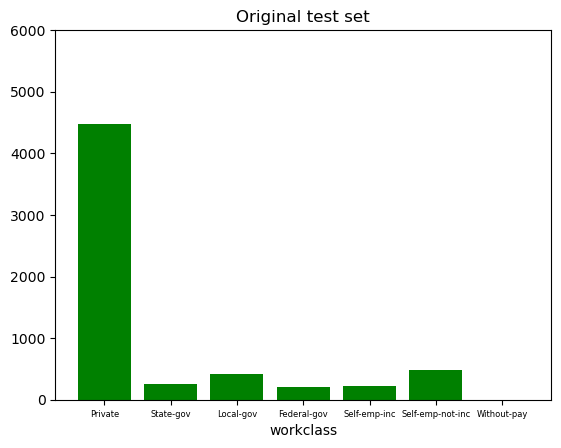

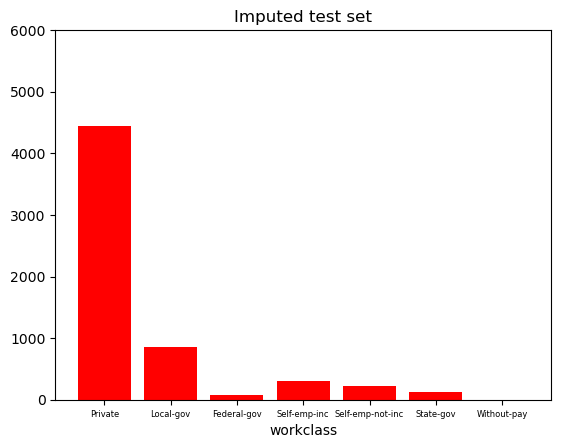

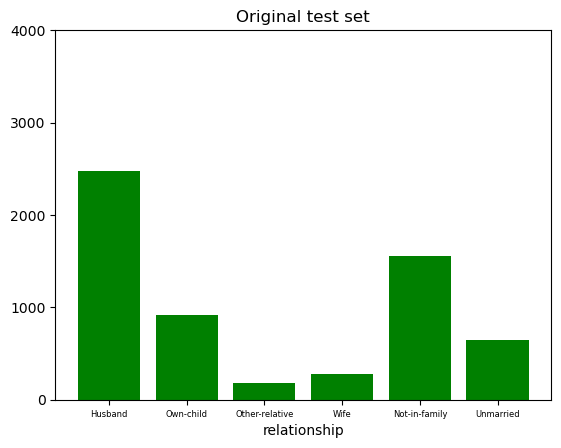

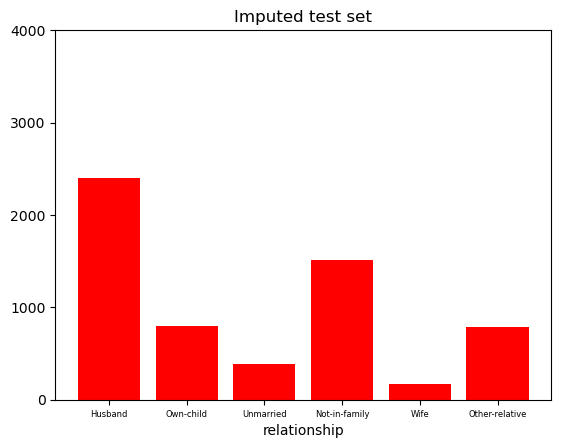

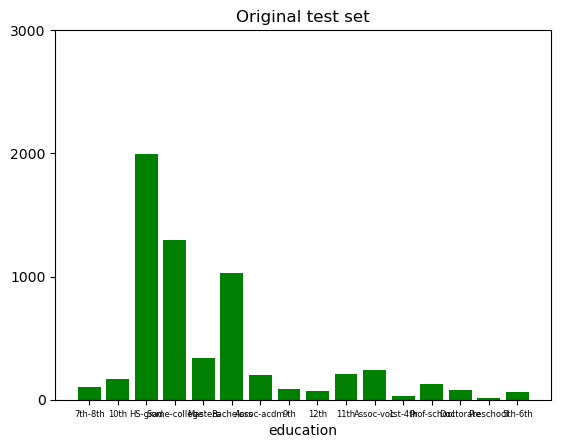

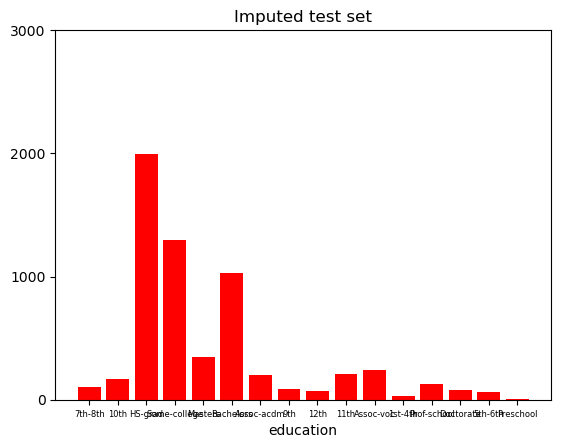

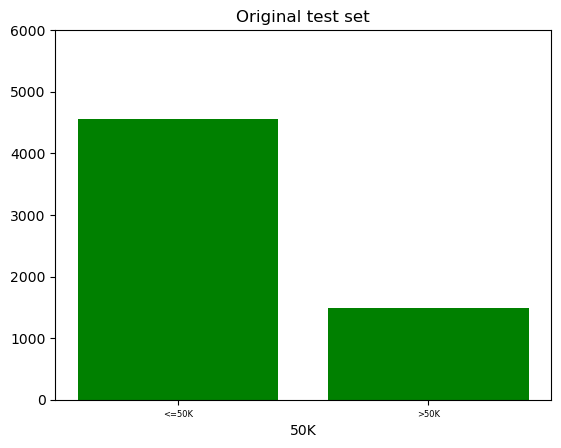

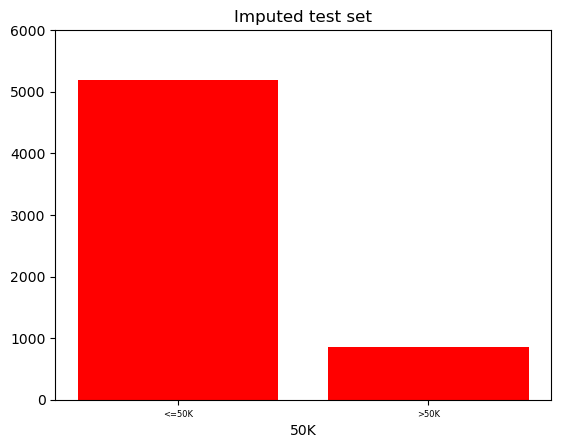

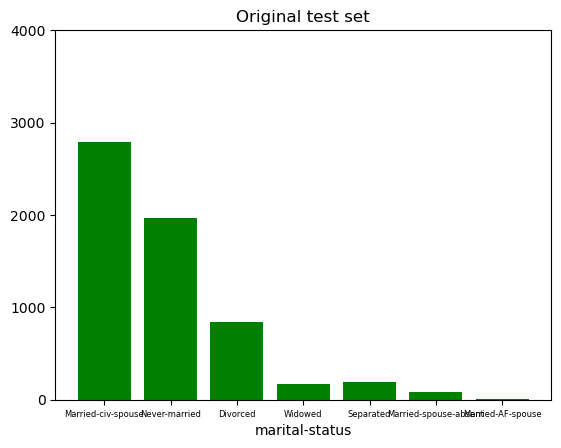

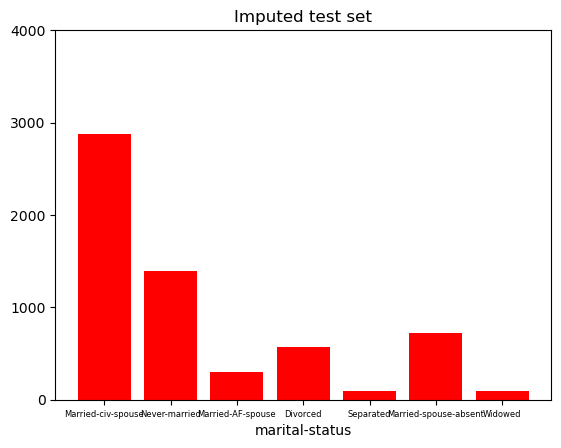

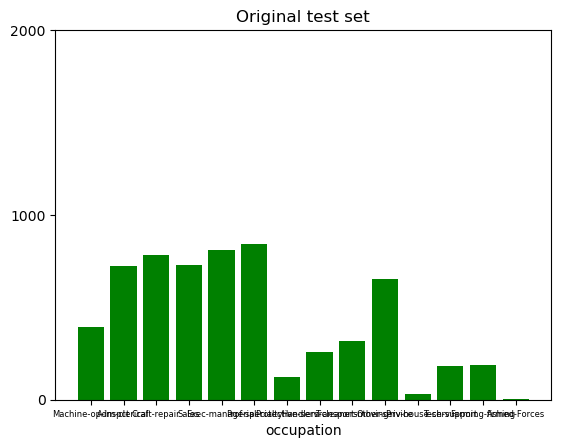

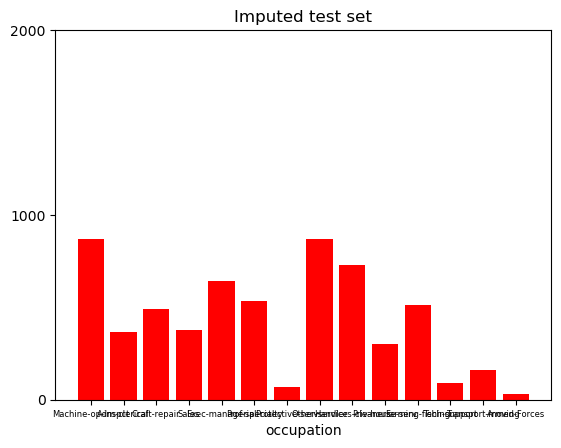

In [21]:
# Histograms: Categorical features

def counts(a): #Function to obtain the counts to each value of the categorical variables
    l={}
   
    for i in a:
        ind=0
        for j in l:
           
            if i==j:
                l[i]+=1
                ind=1
   
        if ind==0:  #not yet in the dictionary
            l[i]=1
           
    return l
           
       
for i in selected_columns: #columns where we removed values to then impute them
    for j in cat_features:
        if i == j: #to make the histogram of categorical features with imputed values:
            
            d1=counts(D_test[i])
            labels=[]
            count=[]
            for k in d1:
                labels.append(k)
                count.append(d1[k])
            
            hist1 = plt.bar(labels, count, color = "green")
            plt.title("Original test set")
            plt.xlabel(i)
            plt.xticks(fontsize=6)
            plt.yticks(np.arange(0, max(count) + 2000, 1000))
            a = max(count)
            
            plt.show()

        
            
            d2=counts(df2_test[i])
            labels=[]
            count=[]
            for k in d2:
                labels.append(k)
                count.append(d2[k])
            
            hist2 = plt.bar(labels, count, color = "red")
            plt.title("Imputed test set")
            plt.xlabel(i)
            plt.xticks(fontsize=6)
            plt.yticks(np.arange(0, a + 2000, 1000))
            
            plt.show()
            

Now, we will measure the quality of the imputation by the accuracy and the mean squared error on the test set.

In [22]:
# Metric: Accuracy

from sklearn.metrics import accuracy_score

# label encoding categorical features
label_encoding(df2_test, cat_features)
label_encoding(D_test, cat_features)
    
print("Categorical features: \n")
for i in cat_features:
    for j in selected_columns:
        if i == j:
            acc_test_column = sklearn.metrics.accuracy_score(D_test[i], df2_test[i])
            print("Accuracy on feature " + i +" = " + str(round(acc_test_column*100,2)) + "%")
        
    


Categorical features: 

Accuracy on feature workclass = 77.67%
Accuracy on feature education = 99.88%
Accuracy on feature marital-status = 74.63%
Accuracy on feature occupation = 54.58%
Accuracy on feature relationship = 73.72%
Accuracy on feature 50K = 89.6%


In [23]:
# Metric: Mean squared error

from sklearn.metrics import mean_squared_error

num_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
cat_features = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country', '50K']

# Fisrtly, we will normalize the values of the numerical features
for i in num_features:
    mean_d = np.mean(D_test[i])
    std_d = np.std(D_test[i])
    mean_d2 = np.mean(df2_test[i])
    std_d2 = np.std(df2_test[i])
    
    for j in df2_test[i].index:
        D_test[i][j] = (D_test[i][j] - mean_d)/std_d
        df2_test[i][j] = (df2_test[i][j] - mean_d2)/std_d2

# And now, we will calculate the mean square error
mse_test_num = 0
mse_test_cat = 0

for i in num_features:
    mse_test_column = mean_squared_error(D_test[i], df2_test[i])
    mse_test_num += mse_test_column
    
# For categorical features, we will assume the distance as 1 if the words to be compared are not equal, and 0 if they are
for j in cat_features:
    dist = 0
    for k in D_test.index:
        if D_test[j][k]==df2_test[j][k]:
            dist += 0
        else:
            dist += 1
    mse_test_cat += dist/len(D_test[j])      
    
        
print(mse_test_num)
print(mse_test_cat)
mse_test = mse_test_num + mse_test_cat
print("Mean squared error on test set = " + str(mse_test))

/tmp/ipykernel_8396/2878398597.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D_test[i][j] = (D_test[i][j] - mean_d)/std_d
/tmp/ipykernel_8396/2878398597.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_test[i][j] = (df2_test[i][j] - mean_d2)/std_d2


0.0
1.299206086668872
Mean squared error on test set = 1.299206086668872
